In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy.stats import *
import datetime
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [350]:
sched = pd.read_csv('https://raw.githubusercontent.com/smallchimp/onoff-NBA/master/schedule_nba.csv') #this does not need to be updated
pbp = pd.read_csv('https://raw.githubusercontent.com/smallchimp/onoff-NBA/master/%5B01-18-2020%5D-%5B01-18-2020%5D-combined-stats.csv') #this does need to be updated daily, 'game_id' column needs to be switched to type-number
pbp['game_id'] = pd.to_numeric(pbp['game_id'], errors='coerce')
pbp['game_id'].fillna(0, inplace = True)
pbp['game_id'] = pbp['game_id'].astype(int)

pbp.head()

,game_id,data_set,date,a1,a2,a3,a4,a5,h1,h2,h3,h4,h5,period,away_score,home_score,remaining_time,elapsed,play_length,play_id,team,event_type,assist,away,home,block,entered,left,num,opponent,outof,player,points,possession,reason,result,steal,type,shot_distance,original_x,original_y,converted_x,converted_y,description
0,21900626,2019-2020 Regular Season,1/18/2020,Rodney McGruder,Kawhi Leonard,Ivica Zubac,Landry Shamet,Patrick Beverley,Josh Hart,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,1,0,0,0:12:00,0:00:00,0:00:00,2,NaN,start of period,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,start of period,NaN,NaN,NaN,NaN,NaN,NaN
1,21900626,2019-2020 Regular Season,1/18/2020,Rodney McGruder,Kawhi Leonard,Ivica Zubac,Landry Shamet,Patrick Beverley,Josh Hart,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,1,0,0,0:12:00,0:00:00,0:00:00,4,NaN,jump ball,NaN,Ivica Zubac,Derrick Favors,NaN,NaN,NaN,NaN,NaN,NaN,Derrick Favors,NaN,NaN,NaN,NaN,NaN,jump ball,NaN,NaN,NaN,NaN,NaN,Jump Ball Favors vs. Zubac: Tip to
2,21900626,2019-2020 Regular Season,1/18/2020,Rodney McGruder,Kawhi Leonard,Ivica Zubac,Landry Shamet,Patrick Beverley,Josh Hart,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,1,3,0,0:11:45,0:00:15,0:00:15,8,LAC,shot,Kawhi Leonard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Landry Shamet,3.0,NaN,NaN,made,NaN,Jump Shot,24.0,-152.0,188.0,40.2,23.8,Shamet 24' 3PT Jump Shot (3 PTS) (Leonard 1 AST)
3,21900626,2019-2020 Regular Season,1/18/2020,Rodney McGruder,Kawhi Leonard,Ivica Zubac,Landry Shamet,Patrick Beverley,Josh Hart,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,1,3,0,0:11:32,0:00:28,0:00:13,10,NOP,turnover,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JJ Redick,NaN,NaN,bad pass,NaN,Rodney McGruder,bad pass,NaN,NaN,NaN,NaN,NaN,"McGruder STEAL (1 STL), Redick Bad Pass Turnov..."
4,21900626,2019-2020 Regular Season,1/18/2020,Rodney McGruder,Kawhi Leonard,Ivica Zubac,Landry Shamet,Patrick Beverley,Josh Hart,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,1,3,0,0:11:29,0:00:31,0:00:03,12,NOP,foul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ivica Zubac,NaN,Brandon Ingram,NaN,NaN,s.foul,NaN,NaN,s.foul,NaN,NaN,NaN,NaN,NaN,Ingram S.FOUL (P1.T1) (B.Barnaky)


In [351]:
##Create Update Merged DF

merged = pd.merge(pbp, sched, on='game_id')

merged['home_lineup'] = merged['h1'] + ", " + merged['h2'] + ", " + merged['h3'] + ", " + merged['h4'] + ", " + merged['h5'] 
merged['away_lineup'] = merged['a1'] + ", " + merged['a2'] + ", " + merged['a3'] + ", " + merged['a4'] + ", " + merged['a5'] 

merged = merged[merged['play_length'] != '00:-12:00']
merged = merged[merged['play_length'] != '00:-5:00']

merged['play_start'] = pd.to_datetime(merged['elapsed'], format='%H:%M:%S') - pd.to_datetime(merged['play_length'], format='%H:%M:%S')
merged['play_end'] = pd.to_datetime(merged['elapsed'], format='%H:%M:%S')


teams = ['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']

merged.head()

,game_id,data_set,date_x,a1,a2,a3,a4,a5,h1,h2,h3,h4,h5,period,away_score,home_score,remaining_time,elapsed,play_length,play_id,team,event_type,assist,away,home,block,entered,left,num,opponent,outof,player,points,possession,reason,result,steal,type,shot_distance,original_x,original_y,converted_x,converted_y,description,date_y,home_abbrev,away_abbrev,home_lineup,away_lineup,play_start,play_end
0,21900626,2019-2020 Regular Season,1/18/2020,Rodney McGruder,Kawhi Leonard,Ivica Zubac,Landry Shamet,Patrick Beverley,Josh Hart,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,1,0,0,0:12:00,0:00:00,0:00:00,2,NaN,start of period,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,start of period,NaN,NaN,NaN,NaN,NaN,NaN,1/18/2020,NOP,LAC,"Josh Hart, Brandon Ingram, Derrick Favors, JJ ...","Rodney McGruder, Kawhi Leonard, Ivica Zubac, L...",00:00:00,1900-01-01 00:00:00
1,21900626,2019-2020 Regular Season,1/18/2020,Rodney McGruder,Kawhi Leonard,Ivica Zubac,Landry Shamet,Patrick Beverley,Josh Hart,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,1,0,0,0:12:00,0:00:00,0:00:00,4,NaN,jump ball,NaN,Ivica Zubac,Derrick Favors,NaN,NaN,NaN,NaN,NaN,NaN,Derrick Favors,NaN,NaN,NaN,NaN,NaN,jump ball,NaN,NaN,NaN,NaN,NaN,Jump Ball Favors vs. Zubac: Tip to,1/18/2020,NOP,LAC,"Josh Hart, Brandon Ingram, Derrick Favors, JJ ...","Rodney McGruder, Kawhi Leonard, Ivica Zubac, L...",00:00:00,1900-01-01 00:00:00
2,21900626,2019-2020 Regular Season,1/18/2020,Rodney McGruder,Kawhi Leonard,Ivica Zubac,Landry Shamet,Patrick Beverley,Josh Hart,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,1,3,0,0:11:45,0:00:15,0:00:15,8,LAC,shot,Kawhi Leonard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Landry Shamet,3.0,NaN,NaN,made,NaN,Jump Shot,24.0,-152.0,188.0,40.2,23.8,Shamet 24' 3PT Jump Shot (3 PTS) (Leonard 1 AST),1/18/2020,NOP,LAC,"Josh Hart, Brandon Ingram, Derrick Favors, JJ ...","Rodney McGruder, Kawhi Leonard, Ivica Zubac, L...",00:00:00,1900-01-01 00:00:15
3,21900626,2019-2020 Regular Season,1/18/2020,Rodney McGruder,Kawhi Leonard,Ivica Zubac,Landry Shamet,Patrick Beverley,Josh Hart,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,1,3,0,0:11:32,0:00:28,0:00:13,10,NOP,turnover,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JJ Redick,NaN,NaN,bad pass,NaN,Rodney McGruder,bad pass,NaN,NaN,NaN,NaN,NaN,"McGruder STEAL (1 STL), Redick Bad Pass Turnov...",1/18/2020,NOP,LAC,"Josh Hart, Brandon Ingram, Derrick Favors, JJ ...","Rodney McGruder, Kawhi Leonard, Ivica Zubac, L...",00:00:15,1900-01-01 00:00:28
4,21900626,2019-2020 Regular Season,1/18/2020,Rodney McGruder,Kawhi Leonard,Ivica Zubac,Landry Shamet,Patrick Beverley,Josh Hart,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,1,3,0,0:11:29,0:00:31,0:00:03,12,NOP,foul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ivica Zubac,NaN,Brandon Ingram,NaN,NaN,s.foul,NaN,NaN,s.foul,NaN,NaN,NaN,NaN,NaN,Ingram S.FOUL (P1.T1) (B.Barnaky),1/18/2020,NOP,LAC,"Josh Hart, Brandon Ingram, Derrick Favors, JJ ...","Rodney McGruder, Kawhi Leonard, Ivica Zubac, L...",00:00:28,1900-01-01 00:00:31


In [352]:
def calc_stats(refined_query):    
    teammates = refined_query['team_lineup'].unique()
    teammates = teammates.tolist()
    teammates = [i.split(", ") for i in teammates]
    flat_teammates = [item for sublist in teammates for item in sublist]
    flat_teammates = list(dict.fromkeys(flat_teammates))
    print(flat_teammates)

    min_log = []
    game_log = []
    point_log = []
    assist_log = []
    rebound_log = []
    block_log = []
    steal_log = []
    turnover_log = []      
    three_log = []
    fgm_log = []
    miss_log = []
    assisting_log = []

    for i in flat_teammates: #minutes played
        player_search = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        player_search['play_length'] = pd.to_datetime(player_search['play_length'], format='%H:%M:%S')
        secs_player = player_search['play_length'].dt.second.sum()
        min_log.append((secs_player)/60)

    for i in flat_teammates: #number of games played
        game_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        game_played = game_count['game_id'].nunique()
        game_log.append(game_played)

    for i in flat_teammates: #number of FGM
        fgm_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        fgm_count = fgm_count[fgm_count['player']==i]
        fgm_count = fgm_count[fgm_count['event_type']=='shot']
        fgm_no = len(fgm_count)
        fgm_log.append(fgm_no)

    for i in flat_teammates: #number of misses
        miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        miss_count = miss_count[miss_count['player']==i]
        miss_count = miss_count[miss_count['event_type']=='miss']
        miss_no = len(miss_count)
        miss_log.append(miss_no)

    for i in flat_teammates: #total points scored
        point_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        player_shots = point_count[point_count['player']==i]
        points = player_shots['points'].sum()
        point_log.append(points)

    for i in flat_teammates: #3 pointers scored
        three_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        three_count = three_count[three_count['player']==i]
        three_count = three_count[three_count['points']==3]
        threes = three_count['points'].sum()
        three_no = threes / 3
        three_log.append(three_no)

    for i in flat_teammates: #assists
        assist_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        assist_count = assist_count[assist_count['assist'].str.contains(i, na=False)==True]
        assist_no = len(assist_count)
        assist_log.append(assist_no)

    for i in flat_teammates: #rebounds
        rebound_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        rebound_count = rebound_count[rebound_count['player'].str.contains(i, na=False)==True]
        rebound_count = rebound_count[rebound_count['event_type']=='rebound']
        rebound_no = len(rebound_count)
        rebound_log.append(rebound_no)

    for i in flat_teammates: #steals
        steal_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        steal_count = steal_count[steal_count['steal'].str.contains(i, na=False)==True]
        steal_no = len(steal_count)
        steal_log.append(steal_no)

    for i in flat_teammates: #blocks
        block_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        block_count = block_count[block_count['block'].str.contains(i, na=False)==True]
        block_no = len(block_count)
        block_log.append(block_no)

    for i in flat_teammates: #turnovers
        turnover_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        turnover_count = turnover_count[turnover_count['player'].str.contains(i, na=False)==True]
        turnover_count = turnover_count[turnover_count['event_type']=='turnover']
        turnover_no = len(turnover_count)
        turnover_log.append(turnover_no)

    for i in flat_teammates: #unassisted fg
        assisting_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        assisting_count = assisting_count[assisting_count['player']==i]
        assisting_count = assisting_count[assisting_count['event_type']=='shot']
        assisting_no = assisting_count['assist'].isnull().sum()
        assisting_log.append(assisting_no)    


    wowy_log = pd.DataFrame(list(map(list, zip(flat_teammates, game_log, fgm_log, miss_log, min_log, point_log, three_log, assist_log, rebound_log, block_log, steal_log, turnover_log, assisting_log))))
    wowy_log.columns = ['Player', 'GP', 'FGM', 'MISS', 'MIN', 'PTS', 'TPM', 'AST', 'REB', 'BLK', 'STL', 'TOV', 'UA']
    wowy_log['MPG'] = wowy_log['MIN'] / wowy_log['GP']
    wowy_log['MIN'] = wowy_log['MIN'].round(2)
    wowy_log['MPG'] = wowy_log['MPG'].round(2)
    wowy_log['FGA'] = wowy_log['FGM'] + wowy_log['MISS']
    wowy_log['FG%'] = wowy_log['FGM'] / wowy_log['FGA']
    wowy_log['FG%'] = wowy_log['FG%'].round(2)
    wowy_log['A'] =  wowy_log['FGM'] - wowy_log['UA']
    wowy_log['%A'] = wowy_log['A'] / wowy_log['FGM']
    wowy_log['%A'] = wowy_log['%A'].round(3)
    pd.set_option('display.expand_frame_repr', False)
    print(wowy_log)
    print("-----------------------------")
    print("")

    team_points = refined_query.groupby(['game_id','team'])['points'].sum()
    only_shots = refined_query[refined_query['event_type']=='shot']
    team_shots = only_shots.groupby(['game_id','team'])['event_type'].count()
    only_misses = refined_query[refined_query['event_type']=='miss']
    team_misses = only_misses.groupby(['game_id','team'])['event_type'].count()
    only_freethrow = refined_query[refined_query['event_type']=='free throw']
    team_freethrow = only_freethrow.groupby(['game_id','team'])['event_type'].count()
    only_turnover = refined_query[refined_query['event_type']=='turnover']
    team_turnover = only_turnover.groupby(['game_id','team'])['event_type'].count()
    only_foul = refined_query[refined_query['event_type']=='foul']
    team_foul = only_foul.groupby(['game_id','team'])['event_type'].count()
    only_orb = refined_query[refined_query['type']=='rebound offensive']
    team_orb = only_orb.groupby(['game_id','team'])['event_type'].count()
    only_drb = refined_query[refined_query['type']=='rebound defensive']
    team_drb = only_drb.groupby(['game_id','team'])['event_type'].count()
    only_no_assists = only_shots[only_shots['assist'].isna()==True]
    team_unassist = only_no_assists.groupby(['game_id','team'])['event_type'].count()

    team_stats = pd.concat([team_points, team_shots, team_misses, team_freethrow, team_turnover, team_foul, team_orb, team_drb, team_unassist], axis=1)
    team_stats.to_csv("team_stats.csv")
    team_stats = pd.read_csv("team_stats.csv") #This is a jerryrig lol

    team_stats.columns = ['game_id', 'Team', 'PTS', 'FGM', 'Miss', 'FTA', 'TOV', 'Foul', 'ORB', 'DRB', 'UA']
    team_stats['FGA'] = team_stats['FGM'] + team_stats['Miss']
    team_stats['FG%'] = team_stats['FGM'] / team_stats['FGA']
    team_stats['FG%'] = team_stats['FG%'].round(3)
    team_stats['A%'] = 1 - (team_stats['UA']/team_stats['FGM'])
    team_stats['A%'] = team_stats['A%'].round(3)


    team_stats['OPP_FGA'] = team_stats.groupby('game_id')['FGA'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_FTA'] = team_stats.groupby('game_id')['FTA'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_ORB'] = team_stats.groupby('game_id')['ORB'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_DRB'] = team_stats.groupby('game_id')['DRB'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_FGM'] = team_stats.groupby('game_id')['FGM'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_TOV'] = team_stats.groupby('game_id')['TOV'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)

    team_part = (team_stats['FGA'] + 0.4 * team_stats['FTA'] - 1.07 * (team_stats['ORB'] / (team_stats['ORB'] + team_stats['OPP_DRB'])) * (team_stats['FGA'] - team_stats['FGM']) + team_stats['TOV'])
    opp_part = (team_stats['OPP_FGA'] + 0.4 * team_stats['OPP_FTA'] - 1.07 * (team_stats['OPP_ORB'] / (team_stats['OPP_ORB'] + team_stats['DRB'])) * (team_stats['OPP_FGA'] - team_stats['OPP_FGM']) + team_stats['OPP_TOV'])


    team_stats['POSS'] = 0.5 * (team_part + opp_part)
    team_stats['POSS'] = team_stats['POSS'].round(2)
    
    return team_stats

In [353]:
#Define Filters

def filter_team(team):
    team_query = merged[(merged.loc[:,'home_abbrev']==team)|(merged.loc[:,'away_abbrev']==team)]
    team_query['team_lineup'] = np.where(team_query.loc[:,'home_abbrev']==team, team_query['home_lineup'], team_query['away_lineup'])
    team_query['team_lineup'] = np.where(team_query.loc[:,'home_abbrev']==team, team_query['home_lineup'], team_query['away_lineup'])
    
    return team_query

def filter_home_away(home_away, df):
    if len(home_away) > 0:
        if home_away == 'home':
            loc_query = df[(df['home_abbrev']==team)]
        elif home_away == 'away':
            loc_query = df[(df['away_abbrev']==team)]
        else:
            print('home_away input incorrect')
            return df
            
        return loc_query
    else:
        return df
    
def filter_date(start_date, end_date, df):
    date_query = df

    if len(start_date) > 0:
        date_query = date_query[date_query['date'] >= start_date]
    if len(end_date) > 0:
         date_query = date_query[date_query['date'] <= end_date]
            
    return date_query
        
def filter_included_players(inc_players, df):
    if len(inc_players) > 0:
        temp_df = pd.DataFrame()

        for p in inc_players:
            player_query = df[df['team_lineup'].str.contains(p)]

            temp_df = temp_df.append(player_query)
        
        return temp_df
    
    else:
        return df
    
def filter_excluded_players(exc_players, df):
    if len(exc_players) > 0:
        temp_df = pd.DataFrame()

        for p in exc_players:
            player_query = df[df['team_lineup'].str.contains(p, na=False)==False]

            temp_df = temp_df.append(player_query)
        
        return temp_df
    
    else:
        return df
    
    
def filter_game_id(game_id, df):
    if len(game_id) > 0:
        temp_df = pd.DataFrame()
        game_query = df[(df['game_id']== int(game_id))]
        
        return game_query
    
    else:
        return df
    
    
def run_filters(team, home_away, start_date, end_date, inc_players, exc_players):
    temp_df = filter_team(team)
    temp_df = filter_home_away(home_away, temp_df)
    temp_df = filter_date(start_date, end_date, temp_df)
    temp_df = filter_included_players(inc_players, temp_df)
    temp_df = filter_excluded_players(exc_players, temp_df)
    
    return temp_df

In [354]:
#Define params and run query   

team = 'NOP'
home_away = ''
start_date = ''
end_date = ''
inc_players = []
exc_players = []


calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))

['Josh Hart', 'Brandon Ingram', 'Derrick Favors', 'JJ Redick', 'Lonzo Ball', 'Jaxson Hayes', "E'Twaun Moore", 'Nickeil Alexander-Walker', 'Frank Jackson', 'Nicolo Melli']
                     Player  GP  FGM  MISS    MIN   PTS  TPM  AST  REB  BLK  STL  TOV  UA    MPG  FGA   FG%  A     %A
0                 Josh Hart   1    4     6  34.55   9.0  1.0    1   10    1    3    3   1  34.55   10  0.40  3  0.750
1            Brandon Ingram   1    7    11  40.50  21.0  2.0    6    7    0    1    4   4  40.50   18  0.39  3  0.429
2            Derrick Favors   1   10     0  28.10  22.0  0.0    3   11    0    1    0   2  28.10   10  1.00  8  0.800
3                 JJ Redick   1    5     7  30.02  19.0  3.0    2    2    0    0    2   1  30.02   12  0.42  4  0.800
4                Lonzo Ball   1    7     9  39.17  18.0  4.0   11   10    1    2    6   4  39.17   16  0.44  3  0.429
5              Jaxson Hayes   1    3     0  15.58  14.0  0.0    4    5    1    0    1   0  15.58    3  1.00  3  1.000
6  

,game_id,Team,PTS,FGM,Miss,FTA,TOV,Foul,ORB,DRB,UA,FGA,FG%,A%,OPP_FGA,OPP_FTA,OPP_ORB,OPP_DRB,OPP_FGM,OPP_TOV,POSS
0,21900626,LAC,133.0,46,47,39,12,29,10,26,24,93,0.495,0.478,86,36,12,36,46,21,108.78
1,21900626,NOP,130.0,46,40,36,21,26,12,36,14,86,0.535,0.696,93,39,10,26,46,12,108.78


In [355]:
#Create a plus-minus statistic for players

def plus_minus(team, player):
    temp_df = filter_team(team)
    temp_df = temp_df[temp_df['home_lineup'].str.contains(player)]
    
    plus = 0
    minus = 0
    
    temp_df = temp_df[temp_df['points'].isna() == False]
    team_points = temp_df[temp_df['team'] == team]
    opp_points = temp_df[temp_df['team'] != team]
    
    return team_points['points'].sum() - opp_points['points'].sum()

In [356]:
plus_minus('NOP','JJ Redick')

11.0

In [357]:
#Create gameflow chart for game

def gameflow(team, game_id, period):
    temp_df = filter_team(team)
    temp_df = filter_game_id(game_id, temp_df)
    temp_df = temp_df[temp_df['period']==period]
    
    teammates = temp_df['team_lineup'].unique()
    teammates = teammates.tolist()
    teammates = [i.split(", ") for i in teammates]
    flat_teammates = [item for sublist in teammates for item in sublist]
    flat_teammates = list(dict.fromkeys(flat_teammates))
    
    fig, ax = plt.subplots()
    ax.set_xlim(temp_df['elapsed'].min(), temp_df['elapsed'].max())
    ax.grid(True)
    
    return flat_teammates

['Josh Hart',
 'Brandon Ingram',
 'Derrick Favors',
 'JJ Redick',
 'Lonzo Ball',
 'Jaxson Hayes',
 "E'Twaun Moore",
 'Nickeil Alexander-Walker',
 'Frank Jackson']

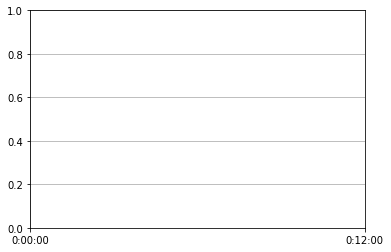

In [358]:
#Define params and run query   

team = 'NOP'
game_id = '21900626'
period = 1

gameflow(team, game_id, period)